## Create folders for dataset split

In [3]:
import os
import shutil

# Create a list of all class names of the dataset
original_dataset_dir = './Desktop/Portfolio/Machine Learning/Identifying_disease_by_leaf/data/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation'
class_names = os.listdir(original_dataset_dir)

# Create a directory for splitted datasets
base_dir = './splitted_data'
if not os.path.isdir(base_dir): # check if the dir already exists
    os.mkdir(base_dir)

# Create subdirectorys for each train/validation/test datasets
train_dir = os.path.join(base_dir, 'train')
if not os.path.isdir(train_dir): 
    os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val')
if not os.path.isdir(val_dir):
    os.mkdir(val_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)

for clss in class_names:
    os.mkdir(os.path.join(train_dir, clss))
    os.mkdir(os.path.join(val_dir, clss))
    os.mkdir(os.path.join(test_dir, clss))


FileExistsError: [WinError 183] Cannot create a file when that file already exists: './splitted_data\\train\\Apple___Apple_scab'

## Data split / Check number of data per each class

In [4]:
import math

# Loop through each class
for clss in class_names:
    # Get all files within the class
    img_path = os.path.join(original_dataset_dir, clss)
    fnames = os.listdir(img_path)
    
    # Set the size of each dataset (6 : 2 : 2)
    train_size = math.floor(len(fnames) * 0.6)
    val_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) - train_size - val_size)
    
    # Initiate the list of train then copy in from the original datset folder
    train_fnames = fnames[:train_size]
    print(f"Train size of {clss}: {len(train_fnames)}")
    for fname in train_fnames:
        src = os.path.join(img_path, fname)
        dest = os.path.join(os.path.join(train_dir, clss), fname)
        shutil.copyfile(src, dest)
        
    # Initiate the list of validation then copy in from the original datset folder
    val_fnames = fnames[:val_size]
    print(f"Validation size of {clss}: {len(val_fnames)}")
    for fname in val_fnames:
        src = os.path.join(img_path, fname)
        dest = os.path.join(os.path.join(val_dir, clss), fname)
        shutil.copyfile(src, dest)
    
    # Initiate the list of test data then copy in from the original dataset folder
    test_fnames = fnames[:test_size]
    print(f"Test size of {clss}: {len(test_fnames)}\n")
    for fname in test_fnames:
        src = os.path.join(img_path, fname)
        dest = os.path.join(os.path.join(test_dir, clss), fname)
        shutil.copyfile(src, dest)

Train size of Apple___Apple_scab: 378
Validation size of Apple___Apple_scab: 126
Test size of Apple___Apple_scab: 126

Train size of Apple___Black_rot: 372
Validation size of Apple___Black_rot: 124
Test size of Apple___Black_rot: 125

Train size of Apple___Cedar_apple_rust: 165
Validation size of Apple___Cedar_apple_rust: 55
Test size of Apple___Cedar_apple_rust: 55

Train size of Apple___healthy: 987
Validation size of Apple___healthy: 329
Test size of Apple___healthy: 329

Train size of Background_without_leaves: 685
Validation size of Background_without_leaves: 228
Test size of Background_without_leaves: 230

Train size of Blueberry___healthy: 901
Validation size of Blueberry___healthy: 300
Test size of Blueberry___healthy: 301

Train size of Cherry___healthy: 512
Validation size of Cherry___healthy: 170
Test size of Cherry___healthy: 172

Train size of Cherry___Powdery_mildew: 631
Validation size of Cherry___Powdery_mildew: 210
Test size of Cherry___Powdery_mildew: 211

Train size 

## Creating data into ImageFolder and DataLoader

In [19]:
import os
import shutil

def remove_ipynb_checkpoints(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Check if '.ipynb_checkpoints' is in the list of directories
        if '.ipynb_checkpoints' in dirnames:
            # Construct the full path to '.ipynb_checkpoints'
            ipynb_checkpoints_path = os.path.join(dirpath, '.ipynb_checkpoints')
            # Print the path for confirmation
            print(f'Removing: {ipynb_checkpoints_path}')
            # Remove the '.ipynb_checkpoints' directory
            shutil.rmtree(ipynb_checkpoints_path)

# Replace 'root_dir' with the path to the directory containing your dataset
remove_ipynb_checkpoints(train_dir)
remove_ipynb_checkpoints(val_dir)
remove_ipynb_checkpoints(test_dir)

In [20]:
import torch

# device-agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from torchvision import transforms
from torchvision.datasets import ImageFolder 

# Setup the transform
image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

# Filter for validity check of file with correct extensions
def is_valid_image(file_path):
    valid_extensions = ('.JPG', '.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
    valid = file_path.endswith(valid_extensions)
    if not valid:
        print(f"Invalid file skipped: {file_path}")
    return valid

# Create ImageFolders
train_dataset = ImageFolder(root=train_dir,
                            transform=image_transform,
                            is_valid_file=is_valid_image) # Skips the invalid files
val_dataset = ImageFolder(root=val_dir,
                          transform=image_transform,
                          is_valid_file=is_valid_image)
test_dataset = ImageFolder(root=test_dir,
                                    transform=image_transform,
                                    is_valid_file=is_valid_image)

from torch.utils.data import DataLoader

BATCH_SIZE = 256

# Create DataLoaders
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count())
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=os.cpu_count())
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=os.cpu_count())

In [21]:
test_dataloader

In [9]:
DEVICE

'cuda'

## Baseline Model

In [11]:
from torch import nn
import torch.nn.functional as F
from torch import optim

class PlantModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32, 
                               kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=64,
                               kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=64, 
                               kernel_size=3, stride=1, padding=1)
        # fully connected(fc)
        self.fc1 = nn.Linear(in_features=4096,
                             out_features=512)
        self.fc2 = nn.Linear(in_features=512,
                             out_features=34) # number of classes = 34
        
    def forward(self, x):
        
        # block 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        # block 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        # block 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        # block 4
        x = x.view(-1, 4096)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

### Createa a baseline model

In [11]:
!nvidia-smi

Thu Dec 14 02:16:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8    N/A /  N/A |      0MiB /  2048MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
baseline_model = PlantModel().to(DEVICE)
optimizer = torch.optim.Adam(params=baseline_model.parameters(),
                             lr=0.001)

## Train function

In [16]:
def train(model: torch.nn.Module, 
          dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module=nn.CrossEntropyLoss()):
    # Put the model into train mode
    model.train()
    train_loss, correct, train_acc = 0, 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Send X, y into the device
        X, y = X.to(DEVICE), y.to(DEVICE)
        
        # forward pass
        pred_probs = model(X)
        
        # Calculate the loss
        loss = loss_fn(pred_probs, y)
        train_loss += loss.item()
        
        # Optimizer zero_grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # optimizer step
        optimizer.step()
        
        pred = torch.argmax(pred_probs, dim=1)
        correct += pred.eq(y.view_as(pred)).sum().item()
        
    train_loss /= len(dataloader)
    train_acc = 100. * correct / len(dataloader.dataset)
    return train_loss, train_acc

In [14]:
len(class_names)

34

## Evaluation function

In [17]:
def evaluate(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             optimizer: torch.optim.Optimizer, 
             loss_fn: torch.nn.Module=nn.CrossEntropyLoss()):
    # Put the model into evaluation mode
    model.eval()
    test_loss, correct, test_acc = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            # Forward pass
            pred_probs = model(X)
            # Accumulate the loss
            test_loss += loss_fn(pred_probs, y).item()
            
            pred = torch.argmax(pred_probs, dim=1)
            correct += pred.eq(y.view_as(pred)).sum().item()
    
    test_loss /= len(dataloader)
    test_acc = 100. * correct / len(dataloader.dataset)
    return test_loss, test_acc

## Train the model

In [32]:
import time
import copy

def train_baseline(model: torch.nn.Module, 
                   train_dataloader: torch.utils.data.DataLoader, 
                   val_dataloader: torch.utils.data.DataLoader,
                   optimizer: torch.optim.Optimizer,
                   loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
                   num_epochs: int=30):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        # Train the model and print save the results
        train_loss, train_acc = train(model=model,
                                      dataloader=train_dataloader, 
                                      optimizer=optimizer,
                                      loss_fn=loss_fn)
        #train_loss, train_acc = evaluate(model=model,
        #                                 dataloader=train_dataloader,
        #                                 optimizer=optimizer,
        #                                 loss_fn=loss_fn)
        
        val_loss, val_acc = evaluate(model=model,
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
        end_time = time.time()
        time_elapsed = end_time - start_time
        print(f"------------ epoch {epoch} ------------")
        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")
        print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:2f}%")
        print(f"Time taken: {time_elapsed / 60:.0f}min {time_elapsed % 60:.0f}s")
        
    model.load_state_dict(best_model_wts)
    return model        

In [17]:
DEVICE

'cuda'

## Train the model

In [34]:
base = train_baseline(model=baseline_model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=nn.CrossEntropyLoss(),
                      num_epochs=15)

------------ epoch 1 ------------
Train loss: 0.3512 | Train acc: 88.37%
Val loss: 0.1429 | Val acc: 95.819702%
Time taken: 5min 46s
------------ epoch 2 ------------
Train loss: 0.3497 | Train acc: 88.55%
Val loss: 0.1373 | Val acc: 96.110505%
Time taken: 4min 16s
------------ epoch 3 ------------
Train loss: 0.3186 | Train acc: 89.37%
Val loss: 0.1105 | Val acc: 96.898098%
Time taken: 4min 15s
------------ epoch 4 ------------
Train loss: 0.3108 | Train acc: 89.59%
Val loss: 0.0995 | Val acc: 97.164667%
Time taken: 4min 15s
------------ epoch 5 ------------
Train loss: 0.3003 | Train acc: 90.19%
Val loss: 0.0969 | Val acc: 97.540288%
Time taken: 4min 16s
------------ epoch 6 ------------
Train loss: 0.2979 | Train acc: 89.94%
Val loss: 0.1330 | Val acc: 95.977220%
Time taken: 4min 15s
------------ epoch 7 ------------
Train loss: 0.2859 | Train acc: 90.46%
Val loss: 0.0851 | Val acc: 97.903793%
Time taken: 4min 14s
------------ epoch 8 ------------
Train loss: 0.2868 | Train acc: 90.

## Save the parameters

In [35]:
torch.save(base, 'baseline.pt')

In [38]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


     ---------------------------------------- 7.6/7.6 MB 22.2 MB/s eta 0:00:00
     ------------------------------------- 187.6/187.6 kB 11.8 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 34.9 MB/s eta 0:00:00
     ---------------------------------------- 56.1/56.1 kB ? eta 0:00:00
     -------------------------------------- 103.1/103.1 kB 5.8 MB/s eta 0:00:00


## Load the saved parameters and test on samples (Visualize!)

In [12]:
trained_model = torch.load('baseline.pt')

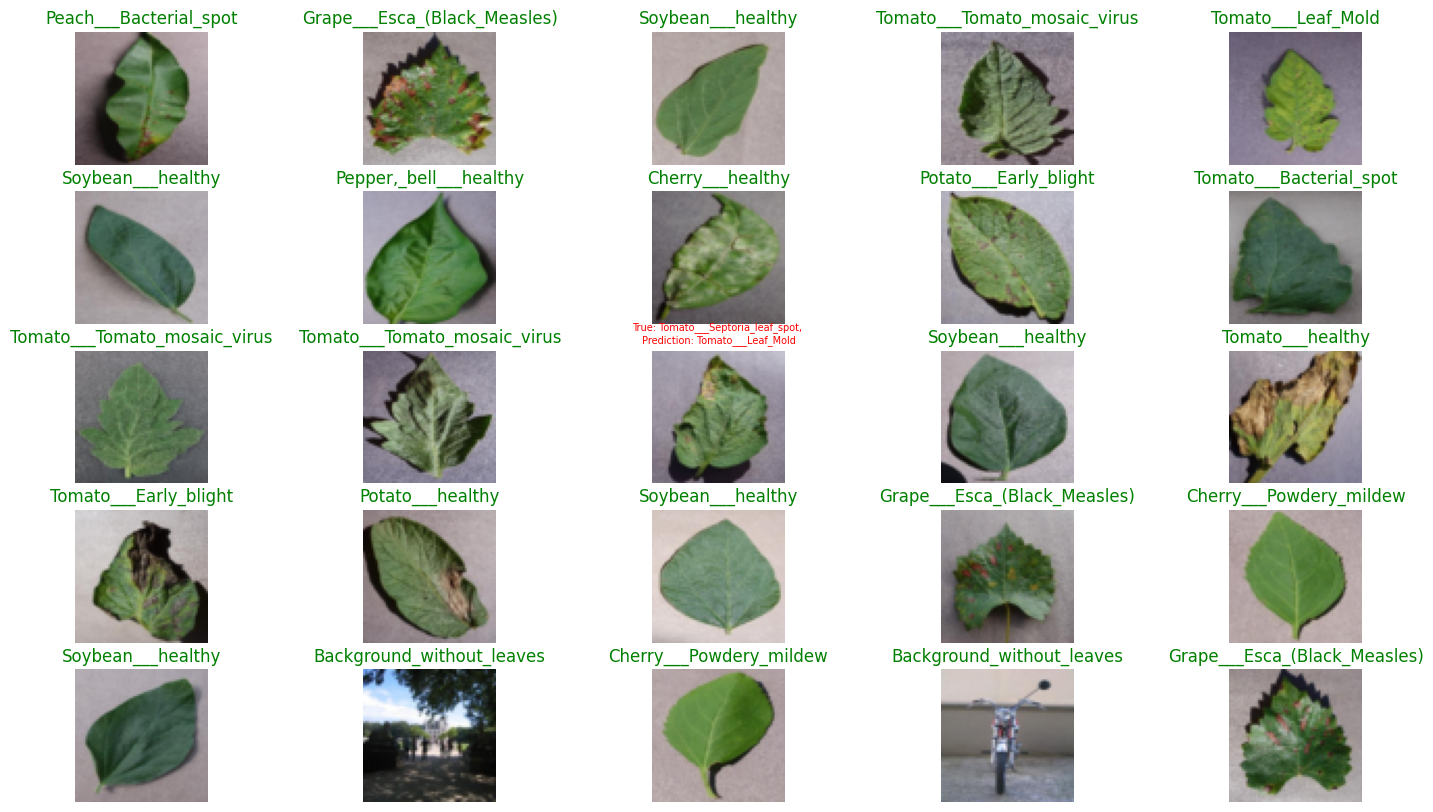

In [105]:
import matplotlib
import matplotlib.pyplot as plt
import random

random_val_idx = random.sample(range(len(val_dataset)), k = 25)

plt.figure(figsize=(18, 10))
for i, target in enumerate(random_val_idx):
    targ_img, targ_label = val_dataset[target][0], val_dataset[target][1]
    pred_probs = trained_model(val_dataset[target][0].to(DEVICE))
    pred_label = torch.argmax(pred_probs, dim=1)
    
    plt.subplot(5, 5, i + 1)
    plt.imshow(targ_img.permute(1, 2, 0))
    plt.axis(False)
    
    if pred_label == targ_label:
        plt.title(class_names[targ_label], c="Green")
    else:
        title = f"True: {class_names[targ_label]}, \nPrediction: {class_names[pred_label]}"
        plt.title(title, c="Red", fontsize = 7)

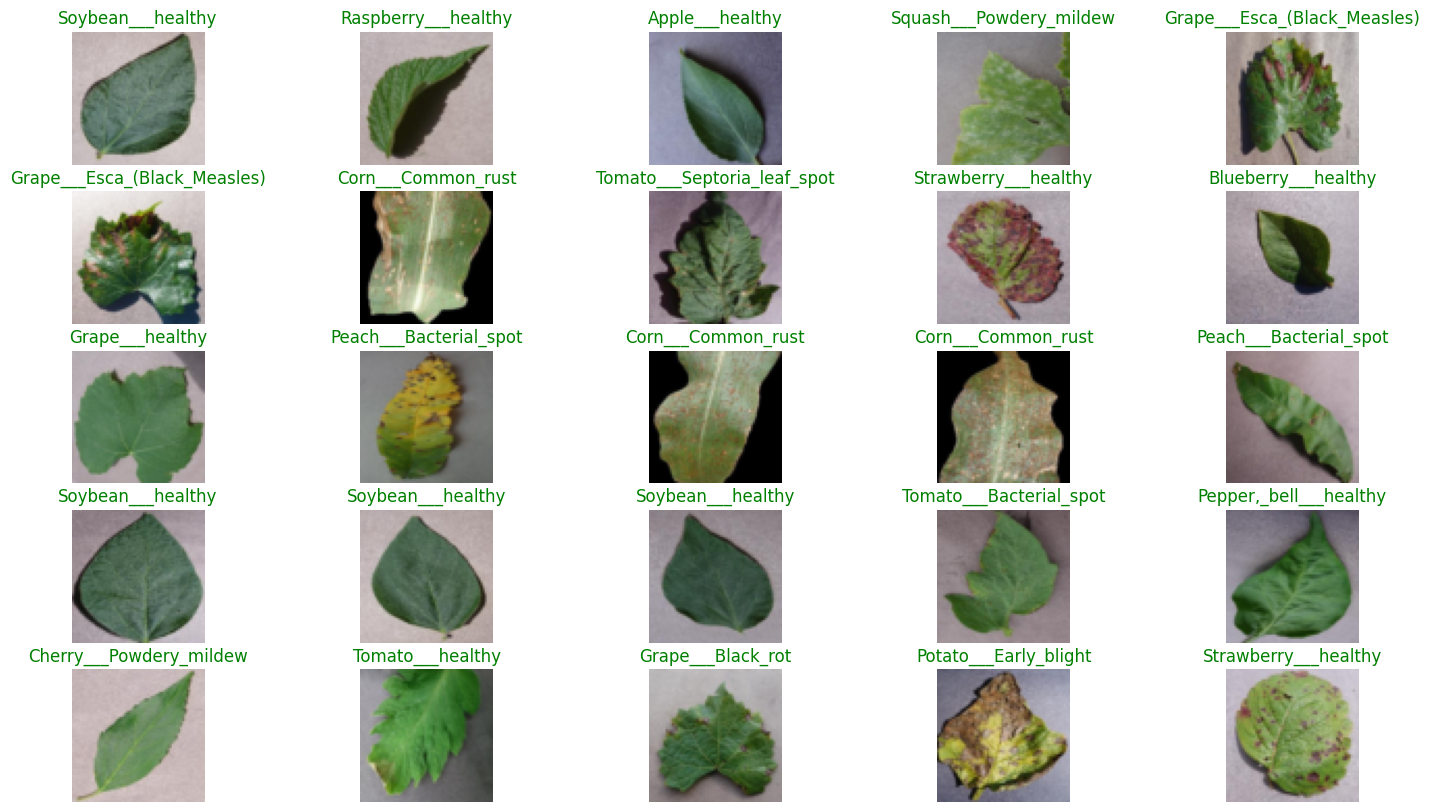

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import random

random_test_idx = random.sample(range(len(test_dataset)), k = 25)

plt.figure(figsize=(18, 10))
for i, target in enumerate(random_test_idx):
    targ_img, targ_label = test_dataset[target][0], test_dataset[target][1]
    pred_probs = trained_model(test_dataset[target][0].to(DEVICE))
    pred_label = torch.argmax(pred_probs, dim=1)
    
    plt.subplot(5, 5, i + 1)
    plt.imshow(targ_img.permute(1, 2, 0))
    plt.axis(False)
    
    if pred_label == targ_label:
        plt.title(class_names[targ_label], c="Green")
    else:
        title = f"True: {class_names[targ_label]}, \nPrediction: {class_names[pred_label]}"
        plt.title(title, c="Red", fontsize = 7)

## Evaluate the baseline model on the test data

In [25]:
trained_model.eval()
test_loss, test_acc = evaluate(trained_model, test_dataloader, optimizer, loss_fn=nn.CrossEntropyLoss())

print(f"baseline test acc: {test_acc}")

baseline test acc: 98.90162945081472
